# Active Learning Meetup

Autor: Luiz Matias

29 de outubro de 2020

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from modAL.uncertainty import uncertainty_sampling
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
import __init__
from src.preprocessing_functions import clean_text

In [748]:
categories = ['rec.sport.baseball', 'rec.sport.hockey', 'rec.motorcycles'] 
twenty_train = fetch_20newsgroups(subset= 'train', categories=categories, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

In [749]:
twenty_train.target_names

['rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

In [750]:
train_data = pd.DataFrame(twenty_train.data, columns=['Text'])
train_data['target'] = twenty_train.target
test_data = pd.DataFrame(twenty_test.data, columns=['Text'])
test_data['target'] = twenty_test.target

In [751]:
train_data['text_clean'] = list(map(clean_text, train_data['Text'].fillna('')))
test_data['text_clean'] = list(map(clean_text, test_data['Text'].fillna('')))

In [752]:
train_data.head()

,Text,target,text_clean
0,"Posted for a friend:\n\nLooking for tires, dim...",0,posted friend looking tires dimensions also lo...
1,\na lot of batters lean in when pitches come. ...,1,lot batters lean pitches come rickey crouch te...
2,"\nI tell you, Steve Stone is like a prophet.\n...",1,tell steve stone like prophet must making ton ...
3,\nTheir phone number is 1-800-377-9777. The la...,1,phone number last catalog shows three oaks jer...
4,"\n\nAnd some comments, with some players delet...",1,comments players deleted yep kevin mitchell ne...


In [753]:
train_data =  train_data[(train_data['text_clean'] != '') & (train_data['text_clean'] != ' ')].reset_index(drop=True)
test_data =  test_data[(test_data['text_clean'] != '') & (test_data['text_clean'] != ' ')].reset_index(drop=True)

In [754]:
train_data.target.value_counts()

2    584
0    583
1    572
Name: target, dtype: int64

In [799]:
df_base, df_pool = train_test_split(train_data, test_size= 0.95, random_state=42)

In [800]:
df_base.target.value_counts()

0    33
1    29
2    24
Name: target, dtype: int64

In [801]:
df_pool.target.value_counts()

2    560
0    550
1    543
Name: target, dtype: int64

In [802]:
tf_idf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer())
])

In [803]:
X_base_sparse = tf_idf.fit_transform(df_base.text_clean)

In [804]:
# Define our LSA transformer and fit it onto our dataset.
svd = TruncatedSVD(n_components=2, random_state=42,  algorithm='arpack')
data = svd.fit_transform(X_base_sparse) 

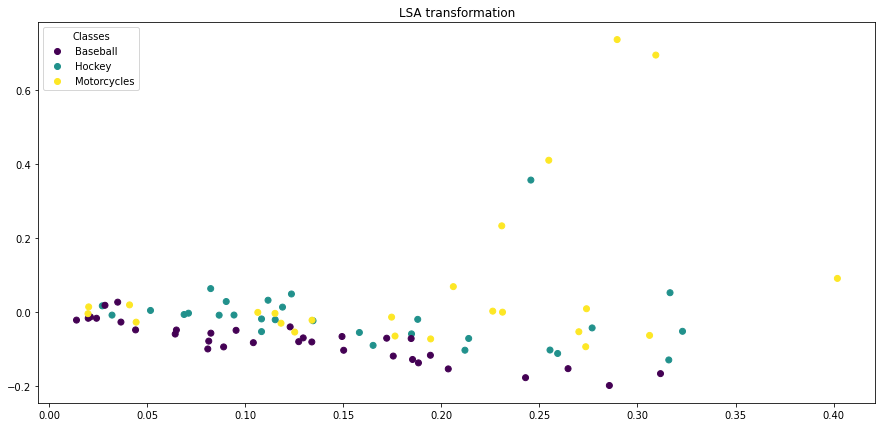

In [805]:
# Isolate the data we'll need for plotting.
x_component, y_component = data[:, 0], data[:, 1]

# Plot our dimensionality-reduced (via LSA) dataset.
fig, ax = plt.subplots(figsize=(15,7))
scatter = ax.scatter(x=x_component, y=y_component, c=df_base.target, cmap='viridis')
classes = ['Baseball', 'Hockey', 'Motorcycles']

legend1 = ax.legend(handles=scatter.legend_elements()[0], labels=classes,
                    loc="upper left", title="Classes")
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
plt.title('LSA transformation')
plt.show()

In [806]:
model = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('SVM', SVC(probability=True, random_state=42))
])

In [807]:
svm = SVC(probability=True, random_state=42)

In [808]:
X_base = df_base.text_clean
y_base = df_base.target

In [809]:
X_test = test_data.text_clean
y_test = test_data.target

In [810]:
model.fit(X_base, y_base)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('SVM', SVC(probability=True, random_state=42))])

In [811]:
first_accuracy = np.round(model.score(X_test, y_test), 4)
first_accuracy

0.4324

In [812]:
X_list_base = []
y_list_base = []
X_list_base += df_base.text_clean.tolist()
y_list_base += df_base.target.tolist()

**modAL.uncertainty.uncertainty_sampling()**

Estratégia de consulta de amostragem de incerteza. Seleciona as instâncias menos seguras para rotulagem.

**Parameters**:	

**classifier** – O classificador

**X** – A amostra de pool para ser rotulada

**n_instances** – Quantas instâncias para serem rotuladas

**Retorna:**	

Os índices das instâncias de X escolhidas para serem rotuladas; as instâncias de X escolhidas para serem rotuladas.

source: https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html

In [813]:
# 4 amostras de 20 instâncias  para serem rotuladas 
N_AMOSTRAS = 35 
N_INSTANCES = 5
performance_history_active = [first_accuracy]

df_pool_active = df_pool.copy().reset_index(drop=True)

X_list_active = X_list_base.copy()
y_list_active = y_list_base.copy()

for index in range(N_AMOSTRAS):
    
    model_active = clone(model)
    model_active.fit(X_list_active, y_list_active)
    
    new_index, new_text = uncertainty_sampling(model_active, df_pool_active.text_clean, n_instances=N_INSTANCES)
        
    X_list_active += new_text.tolist()
    y_list_active += df_pool_active.loc[new_index].target.tolist()
    
    df_pool_active.drop(new_index, inplace=True)
    df_pool_active.reset_index(drop=True, inplace=True)
    
    model_acc = clone(model)
    model_acc.fit(X_list_active, y_list_active)
    score_test = model_acc.score(X_test, y_test)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=(index + 1) * N_INSTANCES, acc=score_test))
    performance_history_active.append(score_test)

Accuracy after query 5: 0.4012
Accuracy after query 10: 0.3934
Accuracy after query 15: 0.4064
Accuracy after query 20: 0.4073
Accuracy after query 25: 0.4775
Accuracy after query 30: 0.5234
Accuracy after query 35: 0.6430
Accuracy after query 40: 0.7782
Accuracy after query 45: 0.6820
Accuracy after query 50: 0.6620
Accuracy after query 55: 0.7158
Accuracy after query 60: 0.7782
Accuracy after query 65: 0.7054
Accuracy after query 70: 0.6837
Accuracy after query 75: 0.7756
Accuracy after query 80: 0.7426
Accuracy after query 85: 0.7860
Accuracy after query 90: 0.6534
Accuracy after query 95: 0.5685
Accuracy after query 100: 0.7227
Accuracy after query 105: 0.6984
Accuracy after query 110: 0.6863
Accuracy after query 115: 0.7981
Accuracy after query 120: 0.7366
Accuracy after query 125: 0.7184
Accuracy after query 130: 0.7383
Accuracy after query 135: 0.8033
Accuracy after query 140: 0.7860
Accuracy after query 145: 0.7678
Accuracy after query 150: 0.7426
Accuracy after query 155: 0.81

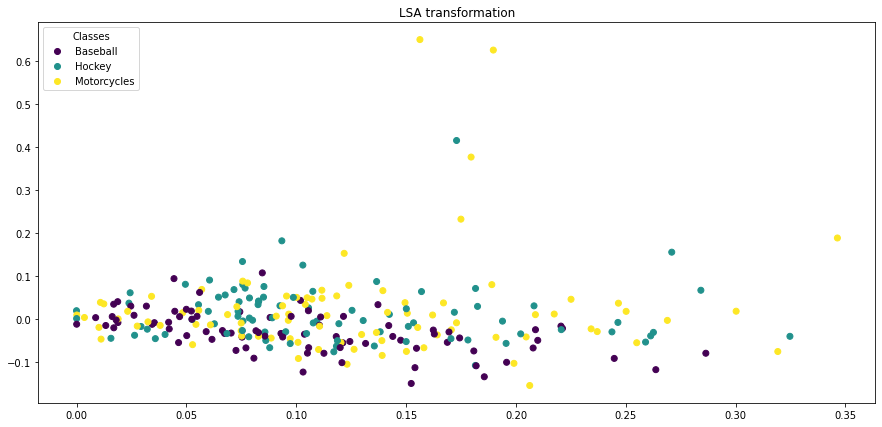

In [814]:
X_sparse = tf_idf.fit_transform(X_list_active)
# Define our LSA transformer and fit it onto our dataset.
svd = TruncatedSVD(n_components=2, random_state=42)
data = svd.fit_transform(X_sparse) 
# Isolate the data we'll need for plotting.
x_component, y_component = data[:, 0], data[:, 1]

# Plot our dimensionality-reduced (via LSA) dataset.
fig, ax = plt.subplots(figsize=(15,7))
scatter = ax.scatter(x=x_component, y=y_component, c=y_list_active, cmap='viridis')
classes =  ['Baseball', 'Hockey', 'Motorcycles']

legend1 = ax.legend(handles=scatter.legend_elements()[0], labels=classes,
                    loc="upper left", title="Classes")
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
plt.title('LSA transformation')
plt.show()

In [815]:
# 4 amostras de 20 instâncias  para serem rotuladas 
N_AMOSTRAS = 35 
N_INSTANCES = 5
performance_history_random = [first_accuracy]

df_pool_random = df_pool.copy().reset_index(drop=True)

X_list_random = X_list_base.copy()
y_list_random = y_list_base.copy()

for index in range(N_AMOSTRAS):
    np.random.seed(0)
       
    new_index = list(np.random.randint(low=0, high=df_pool_random.shape[0], size= N_INSTANCES))
    new_text = df_pool_random.loc[new_index].text_clean
    X_list_random += new_text.tolist()
    y_list_random += df_pool_random.loc[new_index].target.tolist()
    
    df_pool_random.drop(new_index, inplace=True)
    df_pool_random.reset_index(drop=True, inplace=True)
    
    model_acc = clone(model, safe=True)
    model_acc.fit(X_list_random, y_list_random)
    score_test = model_acc.score(X_test, y_test)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=(index + 1) * N_INSTANCES, acc=score_test))
    performance_history_random.append(score_test)

Accuracy after query 5: 0.4281
Accuracy after query 10: 0.4974
Accuracy after query 15: 0.4315
Accuracy after query 20: 0.4844
Accuracy after query 25: 0.5347
Accuracy after query 30: 0.5537
Accuracy after query 35: 0.6144
Accuracy after query 40: 0.6317
Accuracy after query 45: 0.6291
Accuracy after query 50: 0.6170
Accuracy after query 55: 0.5971
Accuracy after query 60: 0.5797
Accuracy after query 65: 0.6049
Accuracy after query 70: 0.5919
Accuracy after query 75: 0.5728
Accuracy after query 80: 0.5442
Accuracy after query 85: 0.5537
Accuracy after query 90: 0.5641
Accuracy after query 95: 0.5685
Accuracy after query 100: 0.5849
Accuracy after query 105: 0.6317
Accuracy after query 110: 0.6274
Accuracy after query 115: 0.6248
Accuracy after query 120: 0.6534
Accuracy after query 125: 0.6672
Accuracy after query 130: 0.6594
Accuracy after query 135: 0.6724
Accuracy after query 140: 0.6889
Accuracy after query 145: 0.7097
Accuracy after query 150: 0.7158
Accuracy after query 155: 0.73

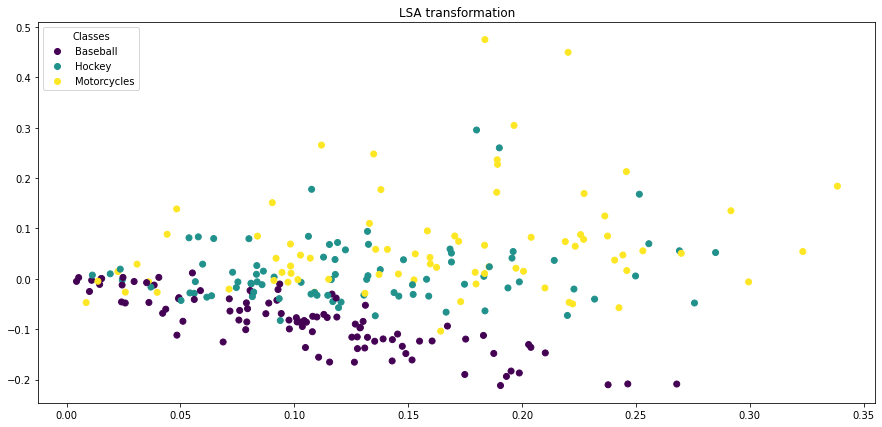

In [816]:
X_sparse = tf_idf.fit_transform(X_list_random)
# Define our LSA transformer and fit it onto our dataset.
svd = TruncatedSVD(n_components=2, random_state=42)
data = svd.fit_transform(X_sparse) 
# Isolate the data we'll need for plotting.
x_component, y_component = data[:, 0], data[:, 1]

# Plot our dimensionality-reduced (via LSA) dataset.
fig, ax = plt.subplots(figsize=(15,7))
scatter = ax.scatter(x=x_component, y=y_component, c= y_list_random, cmap='viridis')
classes =  ['Baseball', 'Hockey', 'Motorcycles']

legend1 = ax.legend(handles=scatter.legend_elements()[0], labels=classes,
                    loc="upper left", title="Classes")
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
plt.title('LSA transformation')
plt.show()

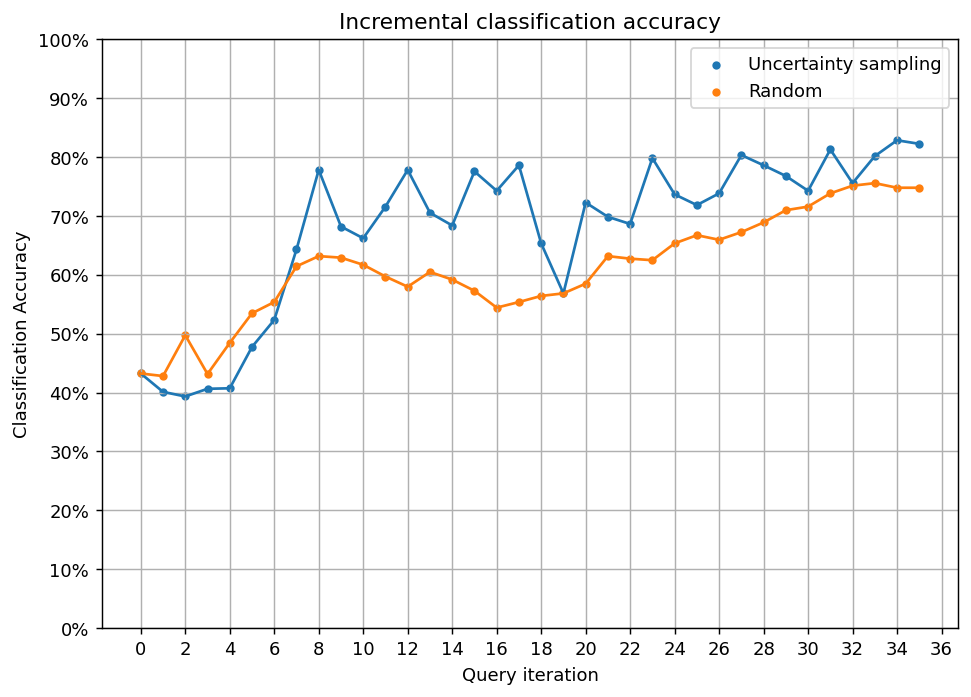

In [817]:
from src.plot_functions import  plot_performance
plot_performance(performance_history_random, performance_history_active)